# COVID-19 ANALYSIS

This is an analysis of the COVID-19 pandemic in South Africa from March to August 2020

# Load libraries

In [2]:
from scipy.integrate import odeint
from datetime import datetime, date

import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#national_report = pd.read_csv('../data/nicd_daily_national_report.csv')
confirmed = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')
transmission = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_transmission_type.csv')
hospitals = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/health_system_za_hospitals_v1.csv')

In [4]:
confirmed['date'] = pd.to_datetime(confirmed['date'], format='%d-%m-%Y')
confirmed.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
174,2020-08-28,20200828,85701.0,36742.0,208579.0,111863.0,12960.0,23765.0,10043.0,24922.0,105507.0,50.0,620123,https://twitter.com/nicd_sa/status/12994458373...
175,2020-08-29,20200829,85899.0,37157.0,209123.0,112291.0,13039.0,23946.0,10284.0,25086.0,105676.0,50.0,622551,https://sacoronavirus.co.za/2020/08/29/update-...
176,2020-08-30,20200830,86060.0,37557.0,209648.0,112726.0,13167.0,24132.0,10568.0,25240.0,105908.0,50.0,625056,https://sacoronavirus.co.za/2020/08/30/update-...


In [5]:
recoveries['date'] = pd.to_datetime(recoveries['date'], format='%d-%m-%Y')
recoveries.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
127,2020-08-28,20200828,81373,23031,179631,95011,11832,21994,6784,18165,96114,0,533935,https://twitter.com/nicd_sa/status/12994458373...
128,2020-08-29,20200829,81373,23047,180345,95432,11961,22291,6887,18437,96921,0,536694,https://sacoronavirus.co.za/2020/08/29/update-...
129,2020-08-30,20200830,81373,23092,181299,95653,12103,22563,6972,18492,97057,0,538604,https://sacoronavirus.co.za/2020/08/30/update-...


In [6]:
deaths['date'] = pd.to_datetime(deaths['date'], format='%d-%m-%Y')
deaths.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
150,2020-08-28,20200828,2863,567,3475,2116,179,330,120,240,3853,0,13743,https://twitter.com/nicd_sa/status/12994458373...
151,2020-08-29,20200829,2869,690,3556,2135,179,330,120,240,3862,0,13981,https://sacoronavirus.co.za/2020/08/29/update-...
152,2020-08-30,20200830,2876,693,3572,2138,179,341,120,240,3869,0,14028,https://sacoronavirus.co.za/2020/08/30/update-...


In [7]:
transmission = transmission.drop(['Unnamed: 4'], axis = 1)
transmission.head(2)

,case_id,transmission_type,type,countries
0,1,Travelled to Italy,travel,italy
1,2,Travelled to Italy,travel,italy


Create a new dataframe with the total number of confirmed positive cases, recoveries and deaths.

In [109]:
# combine the number of cases into a new dataframe
total_cases = pd.concat([confirmed['date'], confirmed['total'],
                         recoveries['total'], deaths['total']], axis=1)

# rename columns
total_cases['confirmed'] = confirmed['total']
total_cases['recoveries'] = recoveries['total']
total_cases['deaths'] = deaths['total']

# convert date column from string to datetime
total_cases['date'] = pd.to_datetime(total_cases['date'], format='%d-%m-%Y')

# drop the repeated columns
total_cases = total_cases.drop(['total', 'total', 'total'], axis=1)

# shift rows down so that dates correspond
total_cases['recoveries'] = total_cases['recoveries'].shift(47)
total_cases['deaths'] = total_cases['deaths'].shift(24)

# fill NAs with zeros
total_cases['recoveries'] = total_cases['recoveries'].fillna(0)
total_cases['deaths'] = total_cases['deaths'].fillna(0)

In [112]:
total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        177 non-null    datetime64[ns]
 1   confirmed   177 non-null    int64         
 2   recoveries  130 non-null    float64       
 3   deaths      153 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.7 KB


In [115]:
# calculate recovery and deaths rates, and create new columns
total_cases['recov_rate'] = (total_cases['recoveries']/total_cases['confirmed'])*100
total_cases['death_rate'] = (total_cases['deaths']/total_cases['confirmed'])*100

# create a month column
total_cases['month'] = total_cases['date'].dt.month

# change month number to month name
total_cases['month'] = total_cases['month'].replace(3, 'March')
total_cases['month'] = total_cases['month'].replace(4, 'April')
total_cases['month'] = total_cases['month'].replace(5, 'May')
total_cases['month'] = total_cases['month'].replace(6, 'June')
total_cases['month'] = total_cases['month'].replace(7, 'July')
total_cases['month'] = total_cases['month'].replace(8, 'August')

In [118]:
# create a dataframe with confirmed cases
confirmed_cases = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=['confirmed', 'recoveries', 'deaths'])

# create a dataframe with death and recovery rates
death_recovery = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=['recov_rate', 'death_rate'])

In [120]:
confirmed_cases.tail(), death_recovery.tail()

(          date   month variable    value
 526 2020-08-26  August   deaths  13502.0
 527 2020-08-27  August   deaths  13628.0
 528 2020-08-28  August   deaths  13743.0
 529 2020-08-29  August   deaths  13981.0
 530 2020-08-30  August   deaths  14028.0,
           date   month    variable     value
 349 2020-08-26  August  death_rate  2.192948
 350 2020-08-27  August  death_rate  2.204158
 351 2020-08-28  August  death_rate  2.216173
 352 2020-08-29  August  death_rate  2.245760
 353 2020-08-30  August  death_rate  2.244279)

Recoveries were recorded only 47 days after the first positive case was confirmed, and deaths were first reported after 24 days. To date there are 525 242 recoveries and 13 502 deaths. 

## Confirmed cases, recoveries and deaths

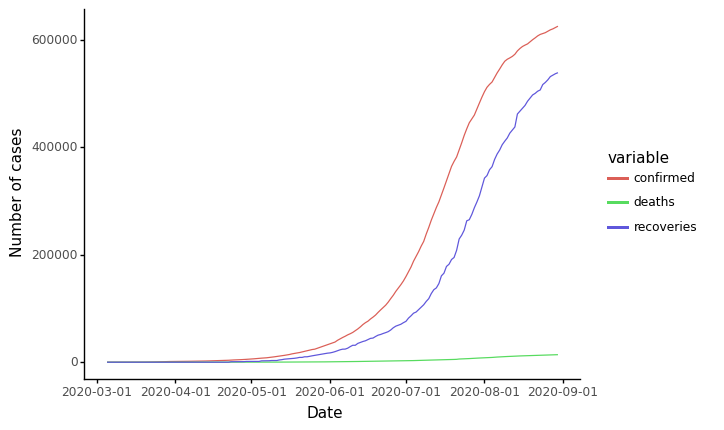

<ggplot: (185784677857)>

In [195]:
(ggplot(confirmed_cases, aes(x='date', y='value', color='variable'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()
 )

On the 15th of March the president declared a national state of disaster and prohibited large gatherings. This was followed by a strict lockdown (Level 5). At this point the number of positive cases was at a minimum. We experienced a spike in positive cases between the beginning of June and mid-August, during Level 3 of lockdown.

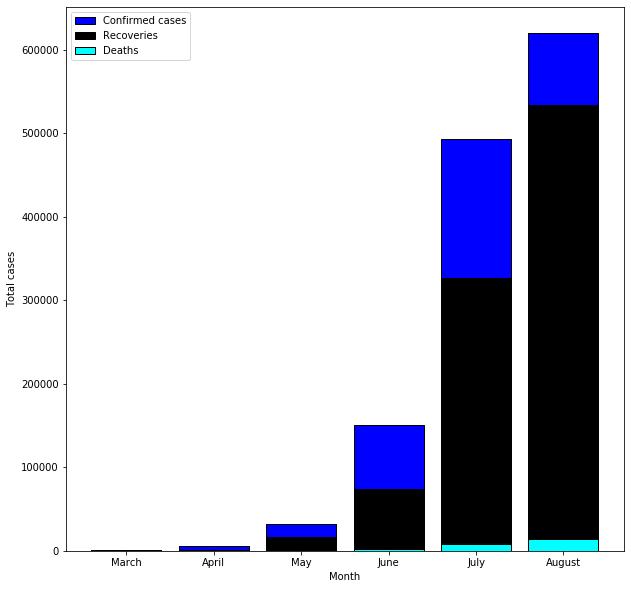

In [60]:
# set figure size
plt.figure(figsize=(10, 10))

# plot all cases in a bar graph
plt.bar(total_cases['month'], total_cases['confirmed'],
        color='blue', edgecolor='black', label='Confirmed cases')
plt.bar(total_cases['month'], total_cases['recoveries'],
        color='black', edgecolor='black', label='Recoveries')
plt.bar(total_cases['month'], total_cases['deaths'],
        color='cyan', edgecolor='black', label='Deaths')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Total cases')
plt.xlabel('Month')

plt.show()

More positive cases were reported from June to July. There has been a positive increase in recoveries and a small proportion of confirmed cases resulted in death.

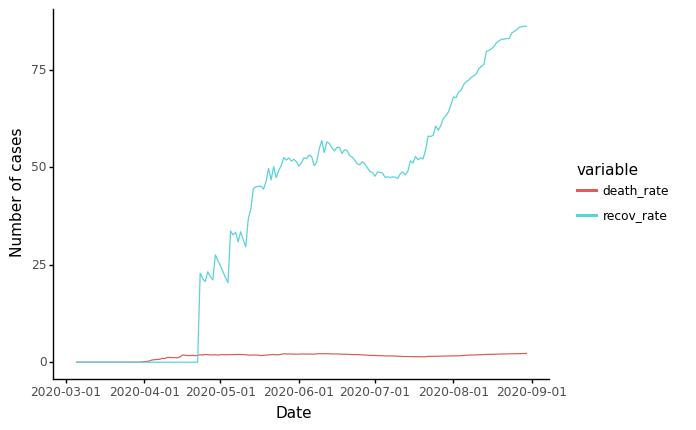

<ggplot: (185780455344)>

In [128]:
(ggplot(death_recovery, aes(x='date', y='value', color='variable'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()
 )

Even with the exponential increase in confirmed cases the death rate has been minimal, with only 2.2% of COVID related deaths being reported to date.

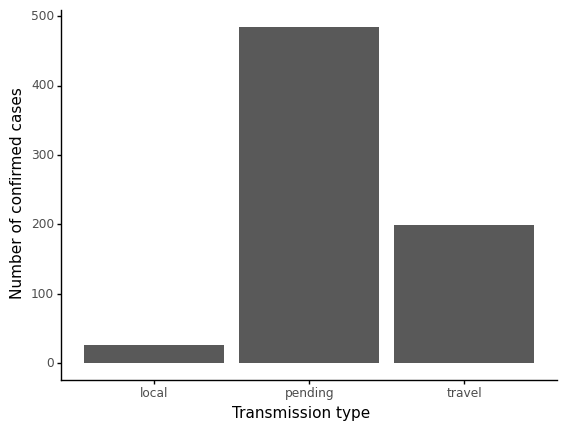

<ggplot: (-9223371851074281237)>

In [32]:
(ggplot(transmission, aes(x='type'))
 + geom_bar()
 + theme_classic()
 + xlab('Transmission type')
 + ylab('Number of confirmed cases')
)

An analysis of cases reported in mid-March (25 March 2020) showed that more people who tested positive for the virus had travelled abroad and contracted the virus in that period. This was before the travel ban was implemented. 

## Cases by province

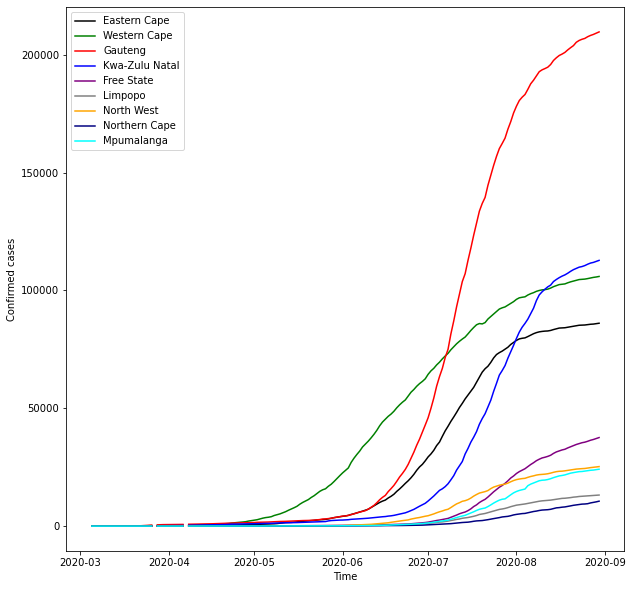

In [196]:
plt.figure(figsize=(10,10))

plt.plot(confirmed['date'], confirmed['EC'],
         color='black', label='Eastern Cape')
plt.plot(confirmed['date'], confirmed['WC'],
         color='green', label='Western Cape')
plt.plot(confirmed['date'], confirmed['GP'],
         color='red', label='Gauteng')
plt.plot(confirmed['date'], confirmed['KZN'],
         color='blue', label='Kwa-Zulu Natal')
plt.plot(confirmed['date'], confirmed['FS'],
         color='purple', label='Free State')
plt.plot(confirmed['date'], confirmed['LP'],
         color='grey', label='Limpopo')
plt.plot(confirmed['date'], confirmed['NW'],
         color='orange', label='North West')
plt.plot(confirmed['date'], confirmed['NC'],
         color='navy', label='Northern Cape')
plt.plot(confirmed['date'], confirmed['MP'],
         color='cyan', label='Mpumalanga')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Confirmed cases')
plt.xlabel('Time')

plt.show()

Gauteng, KZN, the Eastern Cape and the Western Cape have the highest positive cases in the country.

In [171]:
reproductive_rate = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv')

In [187]:
reproductive_rate['date'] = pd.to_datetime(reproductive_rate['date'], format='%Y-%m-%d')

total = reproductive_rate[reproductive_rate['state'] == 'Total RSA']
total.tail()

,state,date,ML,High_90,Low_90
1025,Total RSA,2020-08-06,1.18,1.30,1.04
1026,Total RSA,2020-08-07,0.97,1.09,0.83
1027,Total RSA,2020-08-08,0.82,0.93,0.66
1028,Total RSA,2020-08-09,0.48,0.60,0.32
1029,Total RSA,2020-08-10,0.40,0.52,0.23


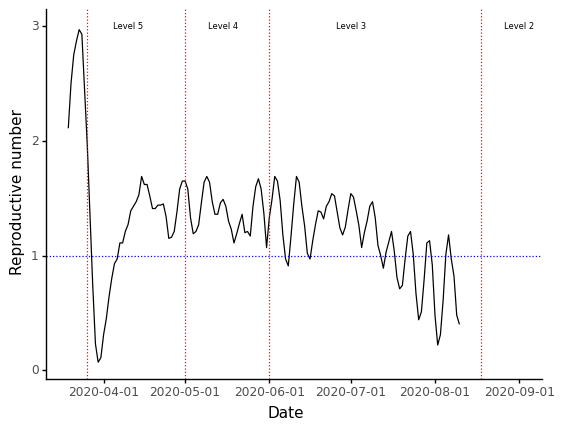

<ggplot: (-9223371851070100252)>

In [194]:
(ggplot(total, aes(x='date', y='ML'))
    + geom_line()
    + labs(x='Date', y='Reproductive number')
    + geom_hline(yintercept=1, linetype='dotted', color='blue')
    + geom_vline(xintercept=['2020-03-26', '2020-05-01',
                             '2020-06-01', '2020-08-18'], linetype='dotted', color='red')
    + annotate('text', x='2020-04-10', y=3, label='Level 5', size=6)
    + annotate('text', x='2020-05-15', y=3, label='Level 4', size=6)
    + annotate('text', x='2020-07-01', y=3, label='Level 3', size=6)
    + annotate('text', x='2020-09-01', y=3, label='Level 2', size=6)
    + theme_classic()
 )

The reproductive number ($R_0$) of a virus indicates how infectious it is. It helps ineastimating how many people will contract the virus from one person who is infected. If the $R_0$ value is above 1 that indicates that the virus is highly contagious and will likely result in an epidemic. The $R_0$ for coronavirus increased up to 3 before the lockdown was implemented. After lockdown restrictions were implemented the reproductive number remained between 1 and 2. Towards the end of level 3 lockdown the reproductive number decreased below 1 suggesting a decline in infection rates.

# SIR Modelling

In order to model how the virus will spread we need to use the SIR model which requires the number of susceptible individuals, those who have been infected and those who have recovered. Two epidemiological quantities are also needed: the reproductive number and the recovery rate. The reproductive number of the virus when the first case was reported was 2.07. At the moment the model does not account for lockdown and travel restrictions.
The code for this model was obtained from scipython.com.

In [202]:
# total population
N = 59431006

# recoveries & active infections
I0 = 1
R0 = 0

# susceptible
S0 = N - I0 - R0

# reproductive number
B = 2.07

# recovery rate
G = 1/14

# set the number of days to 250
t = range(0, 250)

In [203]:
# SIR model differential equations
def derivative(y, t, N, B, G):
    S, I, R = y
    dSdt = -B * S * I / N
    dIdt = B * S * I / N - G * I
    dRdt = G * I
    return dSdt, dIdt, dRdt

In [204]:
# initial conditions
y0 = S0, I0, R0
ret = odeint(derivative, y0, t, args=(N, B, G))
S, I, R = ret.T

# create a dataframe for S, I and R
infection_model = pd.DataFrame(
    {'susceptible': S,
     'infected': I,
     'recovered': R,
     'days': t})

In [205]:
infection_model.tail()

,susceptible,infected,recovered,days
245,0.000015,2.835992,5.943100e+07,245
246,0.000015,2.640486,5.943100e+07,246
247,0.000015,2.458459,5.943100e+07,247
248,0.000015,2.288979,5.943100e+07,248
249,0.000015,2.131183,5.943100e+07,249


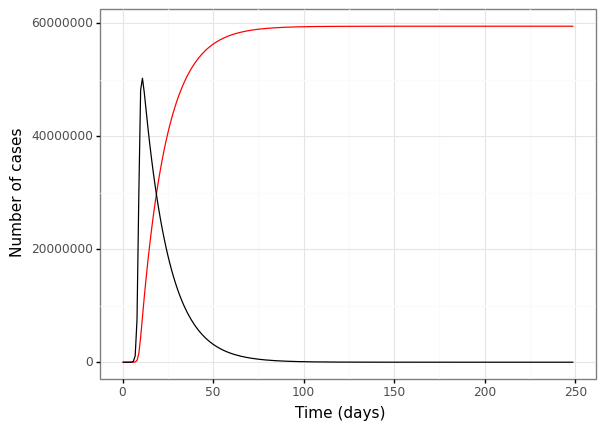

<ggplot: (-9223371851070023529)>

In [206]:
ggplot(infection_model, aes(x='days')) + \
    geom_line(aes(y='recovered'), color='red') + \
    geom_line(aes(y='infected'), color='black') + \
    xlab('Time (days)') + \
    ylab('Number of cases') + \
    theme_bw() + \
    theme()